In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial, signal
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
from IPython.display import display, HTML
import pandas as pd
import pickle
import re
from scanf import scanf

import matplotlib
# matplotlib.use('agg')
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm
from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb

# %matplotlib notebook
%matplotlib inline
rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

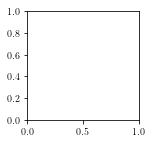

In [2]:
fig = plt.figure(figsize=(2, 2))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)

In [3]:
job_dir = 'ecoC01B05_th1.285_ph2.999_ps0.000'

t_headle = '(.*?).pickle'

In [16]:
def get_major_fre(*arg, **kwargs):
    return spf_tb.get_major_fre(*arg, **kwargs)
    
def load_rand_data_pickle_dir_v3(t_dir, t_headle='(.*?).pickle', n_load=None, rand_mode=False): 
    t_path = os.listdir(t_dir)
    filename_list = [filename for filename in t_path if re.match(t_headle, filename) is not None]
    mean_eta_list = []
    dx_list = []
    dy_list = []
    dz_list = []
    wt_list = []
    pickle_path_list = []
    
    n_load = len(filename_list) if n_load is None else n_load
    assert n_load <= len(filename_list)
    if rand_mode:
        tidx = np.random.choice(len(filename_list), n_load, replace=False)
    else:
        tidx = np.arange(n_load)
    use_filename_list = np.array(filename_list)[tidx]

    for tname in tqdm_notebook(use_filename_list):
        tpath = os.path.join(t_dir, tname)
        with open(tpath, 'rb') as handle:
                tpick = pickle.load(handle)
        pickle_path_list.append(tpath)
        wt_list.append(tpick['omega_tail'])

        # fft rule
        tx = tpick['Table_t']
        tmin = np.max((0, tx.max() - 1000))
        idx = tx > tmin
        freq_pk = get_major_fre(tx[idx], tpick['Table_theta'][idx])
        idx = tx > (tx.max() - 1 / freq_pk * 10)
        mean_eta_list.append(np.mean(tpick['Table_eta'][idx]))
        for i0, tlist in enumerate((dx_list, dy_list, dz_list)):
            tpoly = np.polyfit(tx[idx], tpick['Table_X'][idx, i0], 1, w=np.blackman(idx.sum()))
            tlist.append(tpoly[0])

    dx_list = np.hstack(dx_list)
    dy_list = np.hstack(dy_list)
    dz_list = np.hstack(dz_list)
    wt_list = np.hstack(wt_list)
    mean_eta_list = np.hstack(mean_eta_list)
    pickle_path_list = np.array(pickle_path_list)
    return dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list

In [17]:
n_load = None
rand_mode=False

t_dir = os.path.join(PWD, job_dir)
_ = load_rand_data_pickle_dir_v3(t_dir, t_headle, n_load=n_load, rand_mode=rand_mode)
dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list = _

In [63]:
wt_list.max()

10.0

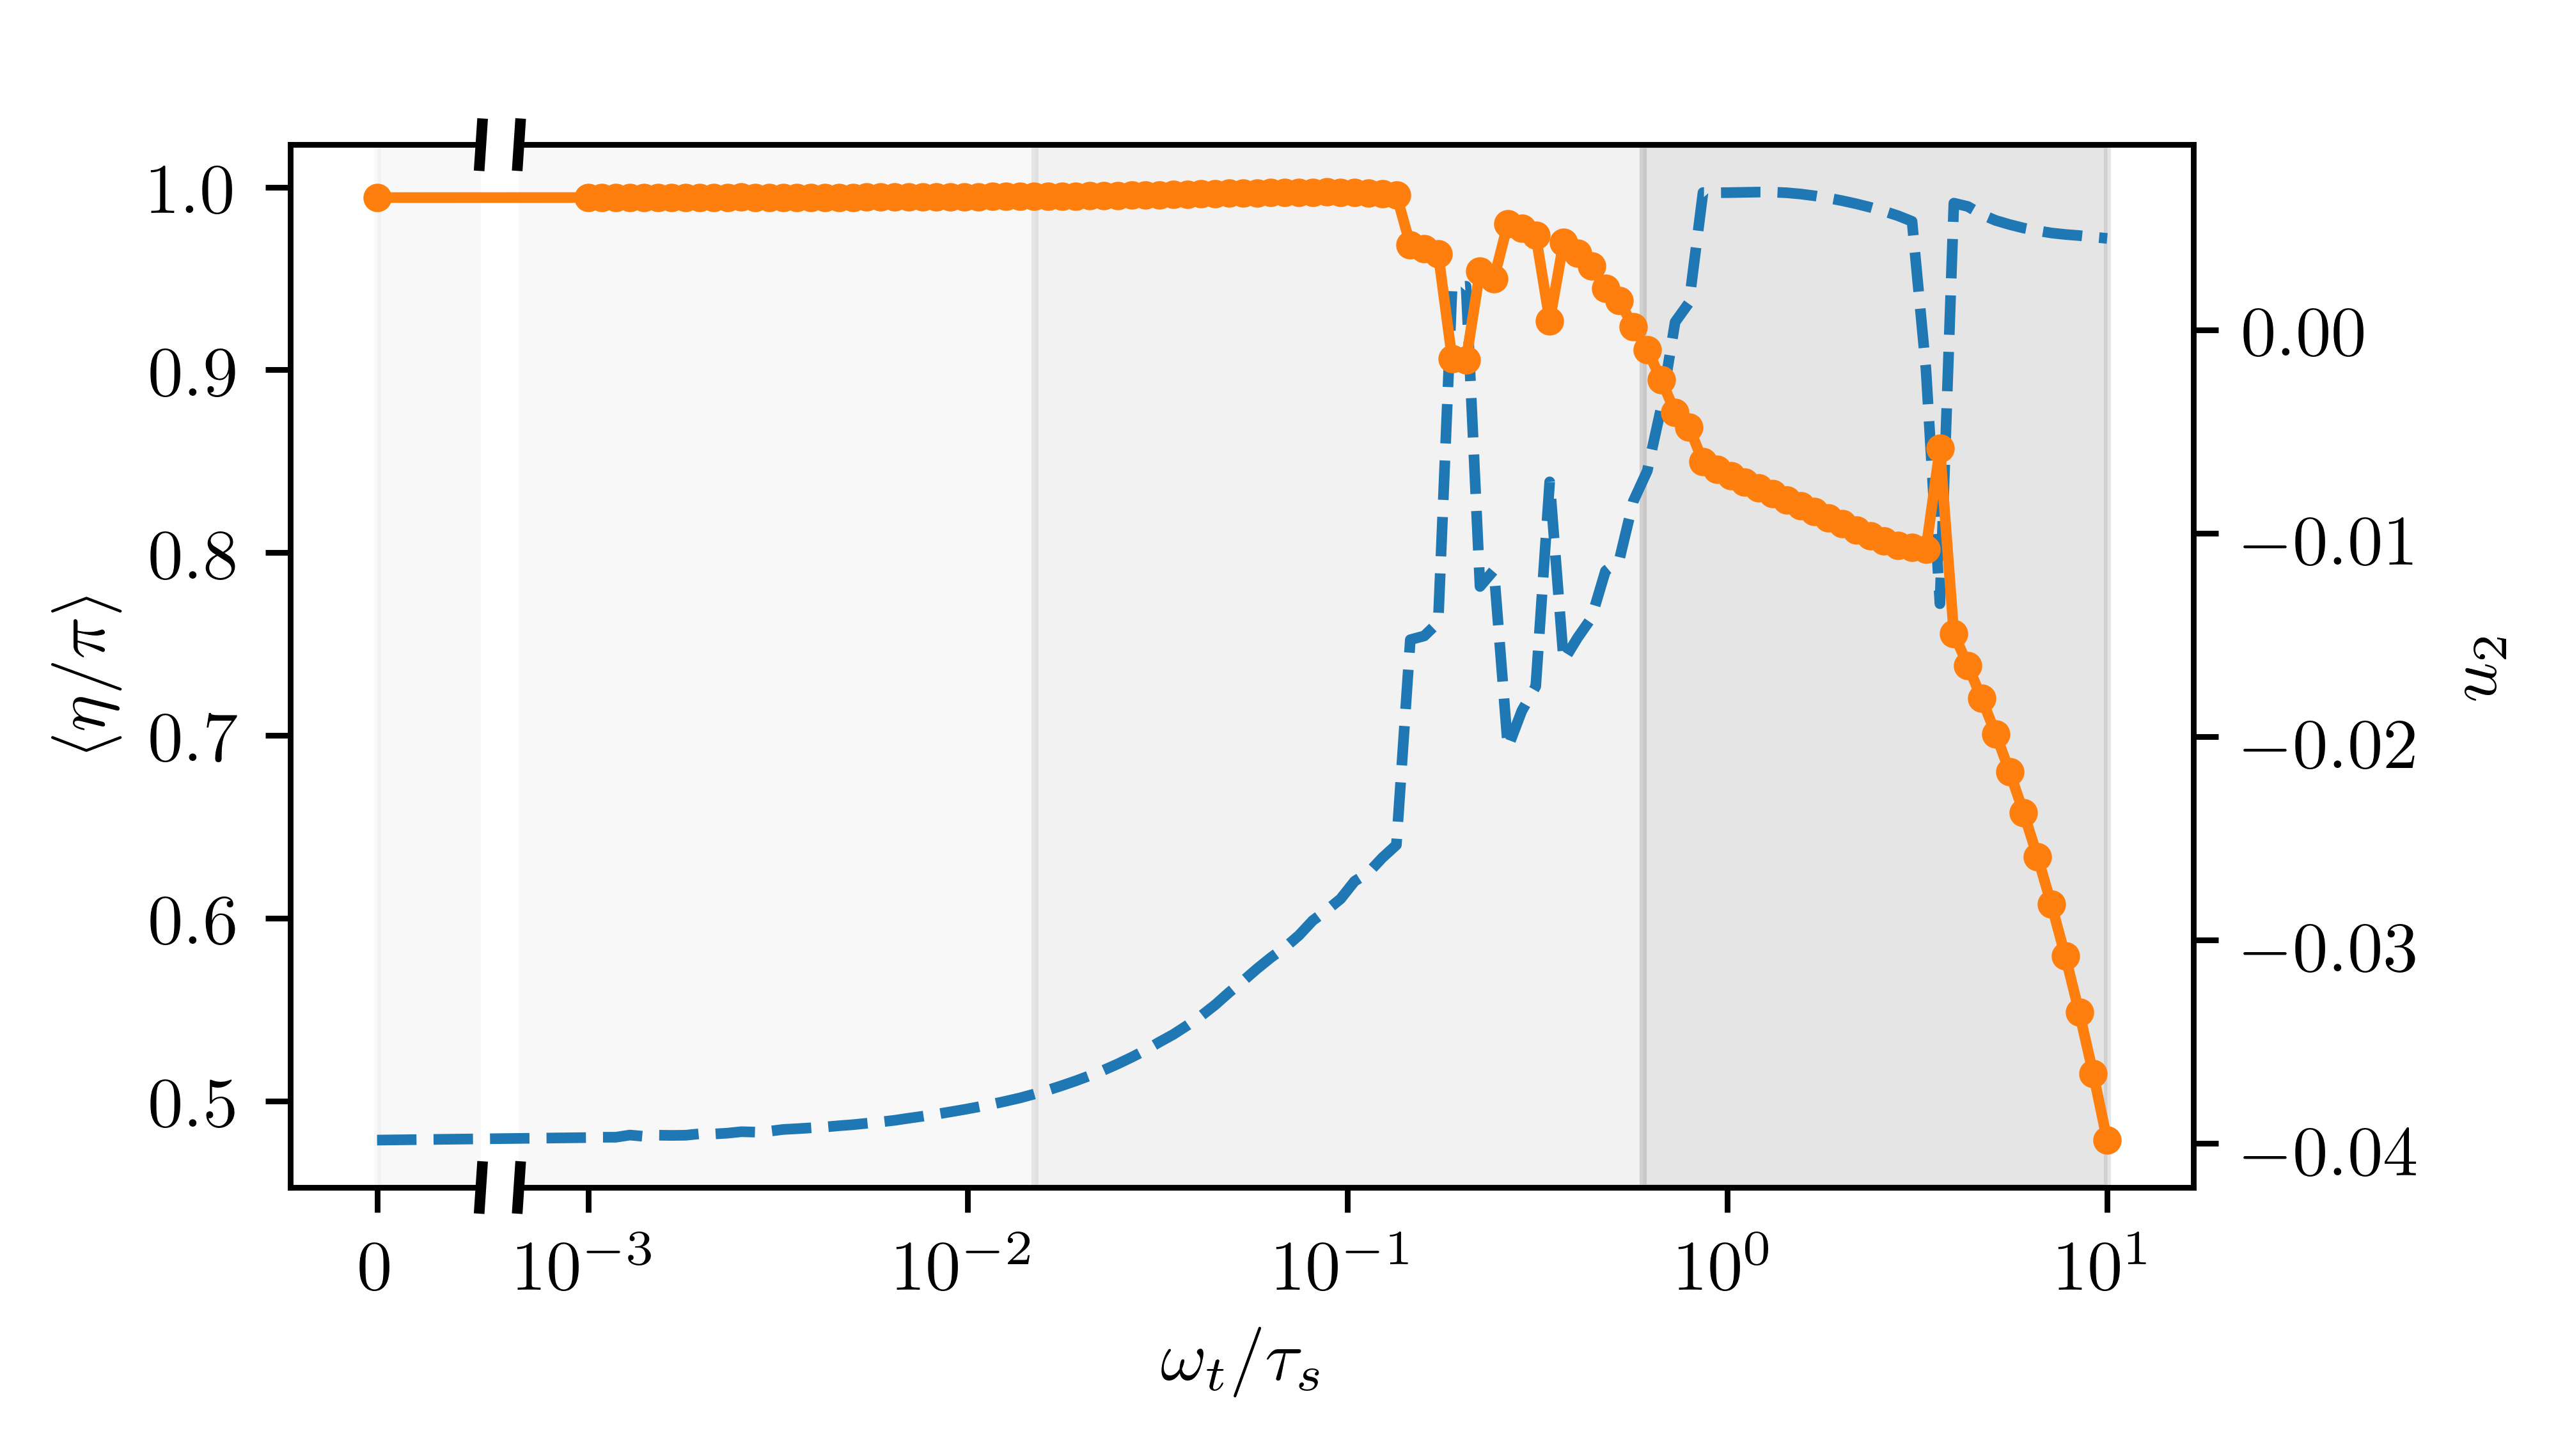

In [100]:
# %matplotlib notebook
%matplotlib inline

figsize = np.array((16, 9)) * 0.3
dpi = 800 if 'inline' in matplotlib.get_backend() else 100
linthreshx = 1e-3
linscalex = 0.5

tidx = np.argsort(wt_list)
fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.1, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.1)))

axi3 = fig.add_axes(axi_pos + dpos)
axi3.set_xticklabels([])
axi3.set_yticklabels([])
for t1 in axi3.spines:
    axi3.spines[t1].set_visible(False)
axi3.tick_params(axis=u'both', which=u'both',length=0)
dpos = np.array(((axi_pos[2] * 0.1, 0, axi_pos[2] * -0.98, 0)))
axi4 = fig.add_axes(axi_pos + dpos)
axi4.set_xticklabels([])
axi4.set_yticklabels([])
for t1 in axi4.spines:
    axi4.spines[t1].set_visible(False)
axi4.tick_params(axis=u'both', which=u'both',length=0)
td = 0.02 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

axi1 = fig.add_axes(axi_pos)
axi1.plot(wt_list[tidx], mean_eta_list[tidx] / np.pi, '--C0', label='th1.285, ph2.999, ps0.000')
axi1.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi1.patch.set_alpha(0)
axi1.set_xlabel('$\\omega_t / \\tau_s$')
axi1.set_ylabel('$\\langle \\eta / \\pi \\rangle$')
axi2 = axi1.twinx()
axi2.plot(wt_list[tidx], dy_list[tidx], '.-C1')
axi2.set_ylabel('$u_2$')
axi2.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
# axi.legend()
for t1 in axi.spines:
    axi1.spines[t1].set_visible(False)
for t1 in axi2.spines:
    axi2.spines[t1].set_visible(False)

axi.set_xlim(axi1.get_xlim())
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.tick_params(axis=u'both', which=u'both',length=0)
axi.set_xticklabels([])
axi.set_yticklabels([])
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')

In [93]:
dpi

150